# Spotify Web Scrapping w Python

## Scrapping from wikipedia

In [1]:
# Import libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Access HTML
url = 'https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify'
headers = {'User-Agent': 'MyWebScrapper/1.0'}
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')

In [3]:
# Subset desired most streamed songs table
tables = soup.find_all('table', class_='wikitable')
most_streamed_songs = tables[0]
most_streamed_songs.find_all('th')[:5]

[<th>Rank
 </th>,
 <th>Song
 </th>,
 <th>Artist(s)
 </th>,
 <th>Streams<br/>(billions)
 </th>,
 <th>Release date
 </th>]

In [4]:
# Extract table headers into table_headers
header_cells = most_streamed_songs.find_all('tr')[0]
table_headers = [cell.get_text(strip=True) for cell in header_cells if cell.get_text(strip=False) != '\n']
table_headers

['Rank', 'Song', 'Artist(s)', 'Streams(billions)', 'Release date', 'Ref.']

In [5]:
# Extract table rows into a table_data
rows = most_streamed_songs.find_all('tr')[1:]

table_data = []
for row in rows:
    song_name = row.find('th').get_text(strip=True).replace('"', '')
    cells = row.find_all('td')

    tmp_content = [cell.get_text(strip=True) for cell in cells]
    tmp_content.insert(1, song_name)

    table_data.append(tmp_content)
    
table_data[:5]

[['1', 'Blinding Lights', 'The Weeknd', '5.002', '29 November 2019', '[1]'],
 ['2', 'Shape of You', 'Ed Sheeran', '4.531', '6 January 2017', '[2]'],
 ['3',
  'Starboy',
  'The WeekndandDaft Punk',
  '4.066',
  '21 September 2016',
  '[3]'],
 ['4',
  'Someone You Loved',
  'Lewis Capaldi',
  '4.034',
  '8 November 2018',
  '[4]'],
 ['5', 'As It Was', 'Harry Styles', '4.023', '1 April 2022', '[5]']]

In [6]:
df_raw = pd.DataFrame(data=table_data, columns=table_headers)
df_raw.head()

,Rank,Song,Artist(s),Streams(billions),Release date,Ref.
0,1,Blinding Lights,The Weeknd,5.002,29 November 2019,[1]
1,2,Shape of You,Ed Sheeran,4.531,6 January 2017,[2]
2,3,Starboy,The WeekndandDaft Punk,4.066,21 September 2016,[3]
3,4,Someone You Loved,Lewis Capaldi,4.034,8 November 2018,[4]
4,5,As It Was,Harry Styles,4.023,1 April 2022,[5]


## Data preprocessing and analysis

In [18]:
df_baking = df_raw.copy()
df_baking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Rank               101 non-null    object
 1   Song               100 non-null    object
 2   Artist(s)          100 non-null    object
 3   Streams(billions)  100 non-null    object
 4   Release date       100 non-null    object
 5   Ref.               100 non-null    object
dtypes: object(6)
memory usage: 4.9+ KB


In [19]:
display(df_baking[df_baking.isna().any(axis=1)]) # This is the last line of the wikipedia table, thus will be dropped
df_baking = df_baking.dropna()

,Rank,Song,Artist(s),Streams(billions),Release date,Ref.
100,As of 2 September 2025,None,None,None,None,None


In [20]:
df_baking.columns = ['rank', 'song', 'artist', 'streams', 'release_date', 'ref.']

### Dtypes:

- Rank column can be dropped, since the rank can be implicitly known by sorting the values by # of streams
- Songs $\rightarrow$ string
- Artists $\rightarrow$ string
- Streams $\rightarrow$ float
- Release date $\rightarrow$ datetime (extract year)
- Ref column can be dropped, since they refer to an external link inside wikipedia, which is not useful for analysis

In [21]:
# Drop unnecesary columns
df_baking = df_baking.drop(columns=['rank', 'ref.'])

In [157]:
# Cleaning artist names 
df_baking["artist"] = df_baking["artist"].str.replace("and", " and ", regex=False)
df_baking["artist"] = df_baking["artist"].str.replace("with", " with ", regex=False)

# Converting str columns
df_baking['song'] = df_baking['song'].astype('string')
df_baking['artist'] = df_baking['artist'].astype('string')

# Converting streams to float
df_baking['streams'] = df_baking['streams'].astype('float16')

In [141]:
# Converting release into date dtype
df_baking['release_date'] = pd.to_datetime(df_baking['release_date']).dt.year
df_baking['release_date']

0     1970
1     1970
2     1970
3     1970
4     1970
      ... 
95    1970
96    1970
97    1970
98    1970
99    1970
Name: release_date, Length: 100, dtype: int32

In [158]:
df_baking.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   song          100 non-null    string 
 1   artist        100 non-null    string 
 2   streams       100 non-null    float16
 3   release_date  100 non-null    int32  
dtypes: float16(1), int32(1), string(2)
memory usage: 2.9 KB


In [160]:
df = df_baking.copy()
df.sample(10)

/workspaces/clases-4geeks/.venv/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,song,artist,streams,release_date
72,See You Again,"Tyler, the Creator and Kali Uchis",2.558594,1970
81,Good 4 U,Olivia Rodrigo,2.492188,1970
25,Señorita,Shawn Mendes and Camila Cabello,3.101562,1970
20,The Night We Met,Lord Huron,3.240234,1970
9,Perfect,Ed Sheeran,3.597656,1970
0,Blinding Lights,The Weeknd,5.003906,1970
98,XO Tour Llif3,Lil Uzi Vert,2.388672,1970
80,Espresso,Sabrina Carpenter,2.496094,1970
84,Happier,Marshmello and Bastille,2.466797,1970
94,505,Arctic Monkeys,2.404297,1970


## Visualization

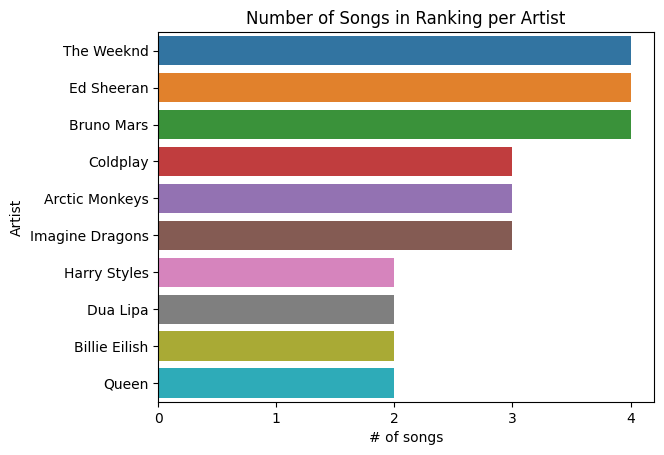

In [165]:
# Most frequent artists on ranking
top_artists = df['artist'].value_counts()[:10]
top_artists.index = top_artists.index

sns.barplot(x=top_artists.values, 
            y=top_artists.index, 
            hue=top_artists.index,
            order=top_artists.index).set_xticks(range(0, 5))
plt.title('Number of Songs in Ranking per Artist')
plt.xlabel('# of songs')
plt.ylabel('Artist')
plt.show()



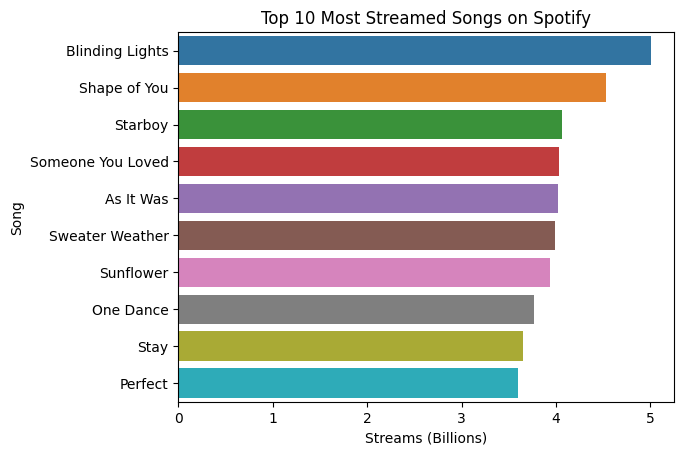

In [167]:
# Most streamed songs in ranking
most_streamed = df.sort_values(by='streams', ascending=False)[:10]

sns.barplot(
    data=most_streamed,
    x='streams', 
    y='song',
    hue='song',
    order=most_streamed['song']
)
plt.xlabel('Streams (Billions)')
plt.ylabel('Song')
plt.title('Top 10 Most Streamed Songs on Spotify')
plt.show()

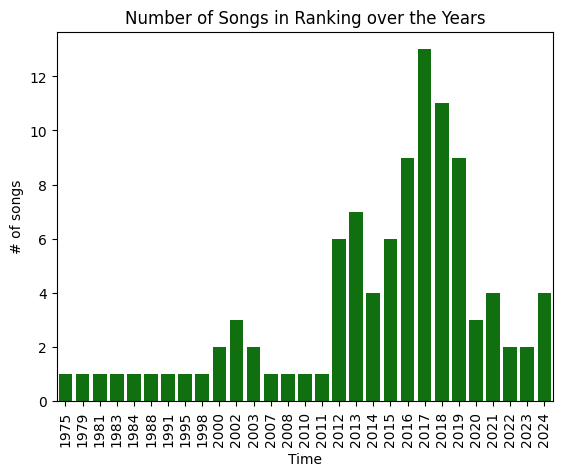

In [79]:
# Songs in ranking by release date
sns.countplot(data=df, x='release_date', color='g')
plt.xticks(rotation=90)
plt.title('Number of Songs in Ranking over the Years')
plt.xlabel('Time')
plt.ylabel('# of songs')
plt.show()

## Insights:
- Mid/late 2010 were the peak years for songs breaking into the ranking.
- 'Blinding lights' and 'Shape of you' dominate all-time streams, outpacing other songs.
- 'Bruno Mars', 'The Weeknd' and 'Ed Sheeran' show sustained success throughout their career, by having 4 solo songs in the ranking.

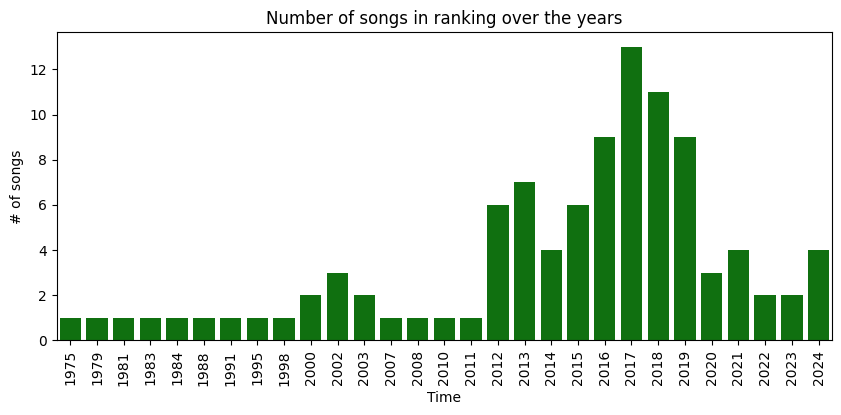

In [67]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='release date', color='g')
plt.xticks(rotation=90)
plt.title('Number of songs in ranking over the years')
plt.xlabel('Time')
plt.ylabel('# of songs')
plt.show()

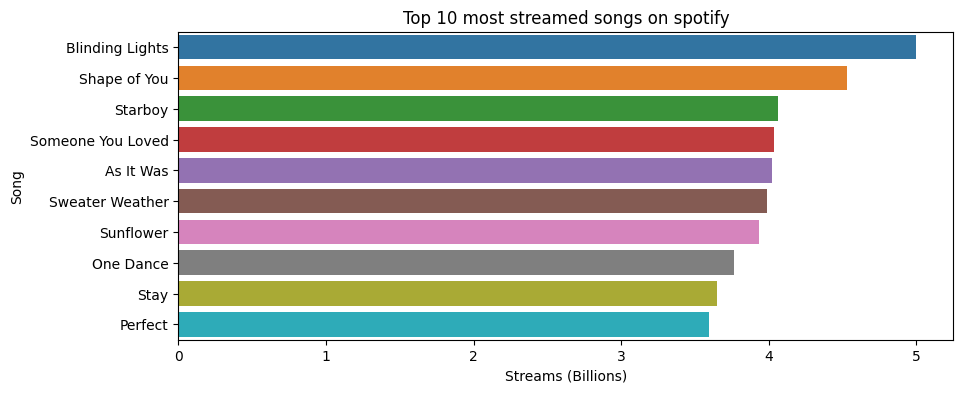

In [136]:
# Streams vs songs
plt.figure(figsize=(10, 4))
sns.barplot(
    data=df.sort_values(by='streams(billions)', ascending=False)[:10], 
    x='streams(billions)', 
    y='song',
    hue='song'
)
plt.xlabel('Streams (Billions)')
plt.ylabel('Song')
plt.title('Top 10 most streamed songs on spotify')
plt.show()

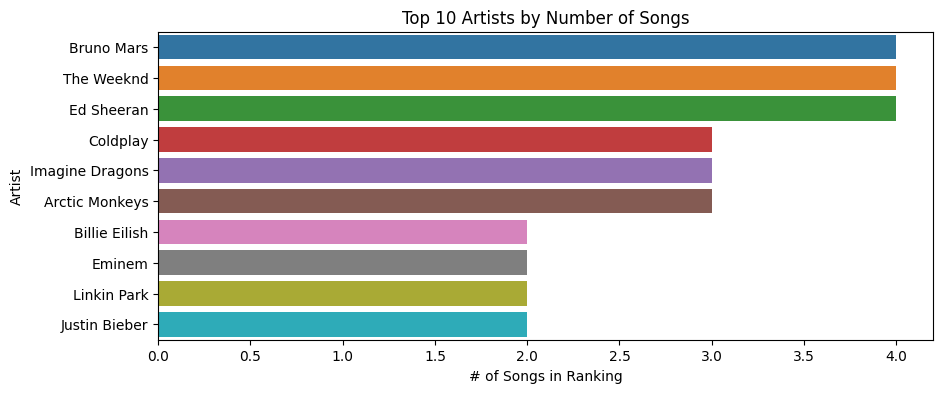

In [135]:
# Artists vs songs in ranking
top10 = df["artist(s)"].value_counts().nlargest(10)

plt.figure(figsize=(10, 4))
sns.barplot(x=top10.values, y=top10.index.tolist(), orient="h", hue=top10.index.tolist())
plt.title("Top 10 Artists by Number of Songs")
plt.xlabel("# of Songs in Ranking")
plt.ylabel("Artist")
plt.show()

### Insights
- Mid/late 2010 were the peak years for songs breaking into the ranking.
- 'Blinding lights' and 'Shape of you' dominate all-time streams, outpacing other songs. 
- 'Bruno Mars', 'The Weeknd' and 'Ed Sheeran' show sustained success throughout their career, by having 4 solo songs in the ranking.